In [1]:
# New first cell for notebooks 1, 2, 3, and 4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the single, fully-prepared data file
df = pd.read_csv('../output/processed_data/analysis_ready_data.csv')

# Cell 2: Markdown
"""
## Deliverable 2: Flight Difficulty Score Development
This notebook details the creation of a systematic, daily-level scoring system to quantify flight complexity. The goal is to move beyond manual identification and create a data-driven tool for proactive planning.
"""


# Cell 3: Markdown
"""
### Step 1: Advanced Feature Engineering
To accurately capture operational complexity, we created several new features that act as proxies for difficulty. We focused on three key areas: aircraft complexity, time-based pressure, and high-risk operational scenarios.
"""

In [2]:
# Cell 4: Code for Advanced Features
# Fleet Complexity Score
def assign_fleet_complexity(fleet_type):
    if any(s in str(fleet_type) for s in ['B777', 'B787', 'B767']): return 3 # High
    if any(s in str(fleet_type) for s in ['B737', 'A320', 'A319']): return 2 # Medium
    if any(s in str(fleet_type) for s in ['ERJ', 'CRJ']): return 1 # Low
    return 1
df['fleet_complexity_score'] = df['fleet_type'].apply(assign_fleet_complexity)

# Time of Day Pressure
df['departure_hour'] = pd.to_datetime(df['scheduled_departure_datetime_local']).dt.hour
def assign_time_pressure(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 19: return 3 # High
    if 5 <= hour <= 6 or 10 <= hour <= 15 or 20 <= hour <= 21: return 2 # Medium
    return 1 # Low
df['time_pressure_score'] = df['departure_hour'].apply(assign_time_pressure)

# High-Risk Transfer Flag
df['transfer_bag_ratio'] = df['Transfer'] / (df['Checked'] + df['Transfer']).replace(0, np.nan)
df['transfer_bag_ratio'].fillna(0, inplace=True)
high_transfer_threshold = df.groupby('scheduled_departure_date_local')['transfer_bag_ratio'].transform(lambda x: x.quantile(0.75))
low_ground_time_threshold = df.groupby('scheduled_departure_date_local')['ground_time_deficit'].transform(lambda x: x.quantile(0.25))
df['is_high_risk_transfer'] = ((df['transfer_bag_ratio'] >= high_transfer_threshold) & (df['ground_time_deficit'] <= low_ground_time_threshold)).astype(int)

print("Advanced features created successfully.")
df[['flight_number', 'fleet_type', 'fleet_complexity_score', 'departure_hour', 'time_pressure_score', 'is_high_risk_transfer']].head()

Advanced features created successfully.


C:\Users\aakan\AppData\Local\Temp\ipykernel_20444\2727467271.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['transfer_bag_ratio'].fillna(0, inplace=True)


,flight_number,fleet_type,fleet_complexity_score,departure_hour,time_pressure_score,is_high_risk_transfer
0,4792,ERJ-175,1,17,3,1
1,920,B767-300,3,18,3,0
2,1776,B737-800,2,18,3,0
3,5790,CRJ-200,1,18,3,0
4,1398,B737-800,2,18,3,0


# Cell 5: Markdown
"""
### Step 2: The Daily Scoring Engine
The core of our solution is a **Daily Percentile Rank** methodology. This approach was chosen because operational difficulty is relative. A flight that is 'difficult' on a quiet Tuesday might be 'easy' on a busy Friday. This method ensures the score is always contextually relevant to the specific day's operations.

**How it works:**
1. For each difficulty factor (e.g., load factor), we rank every flight *only against other flights on the same day*.
2. This converts absolute values (e.g., 200 passengers) into a relative rank (0.0 to 1.0).
3. The final score is the average of all these daily ranks.
"""

In [3]:
# Cell 6: Code for Daily Scoring
difficulty_features = {
    'load_factor': True, 'ssr_per_pax': True, 'child_ratio': True, 'basic_economy_ratio': True,
    'bags_per_pax': True, 'is_international': True, 'ground_time_deficit': False,
    'fleet_complexity_score': True, 'time_pressure_score': True, 'is_high_risk_transfer': True
}
score_ranks = []
for feature, higher_is_worse in difficulty_features.items():
    rank_col = f'{feature}_rank'
    df[rank_col] = df.groupby('scheduled_departure_date_local')[feature].rank(pct=True)
    if not higher_is_worse: df[rank_col] = 1 - df[rank_col]
    score_ranks.append(rank_col)

df['difficulty_score'] = df[score_ranks].mean(axis=1) * 100
df['difficulty_rank_daily'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='dense', ascending=False)
df['difficulty_class'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].transform(
    lambda x: pd.qcut(x, q=[0, 0.33, 0.66, 1.0], labels=['Easy', 'Medium', 'Difficult'], duplicates='drop')
)

print("Daily difficulty score, rank, and class have been calculated.")

Daily difficulty score, rank, and class have been calculated.



--- Visualizing the Scoring Results ---


C:\Users\aakan\AppData\Local\Temp\ipykernel_20444\3795368713.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='difficulty_class', data=df, order=['Easy', 'Medium', 'Difficult'], palette='viridis', ax=axes[1])


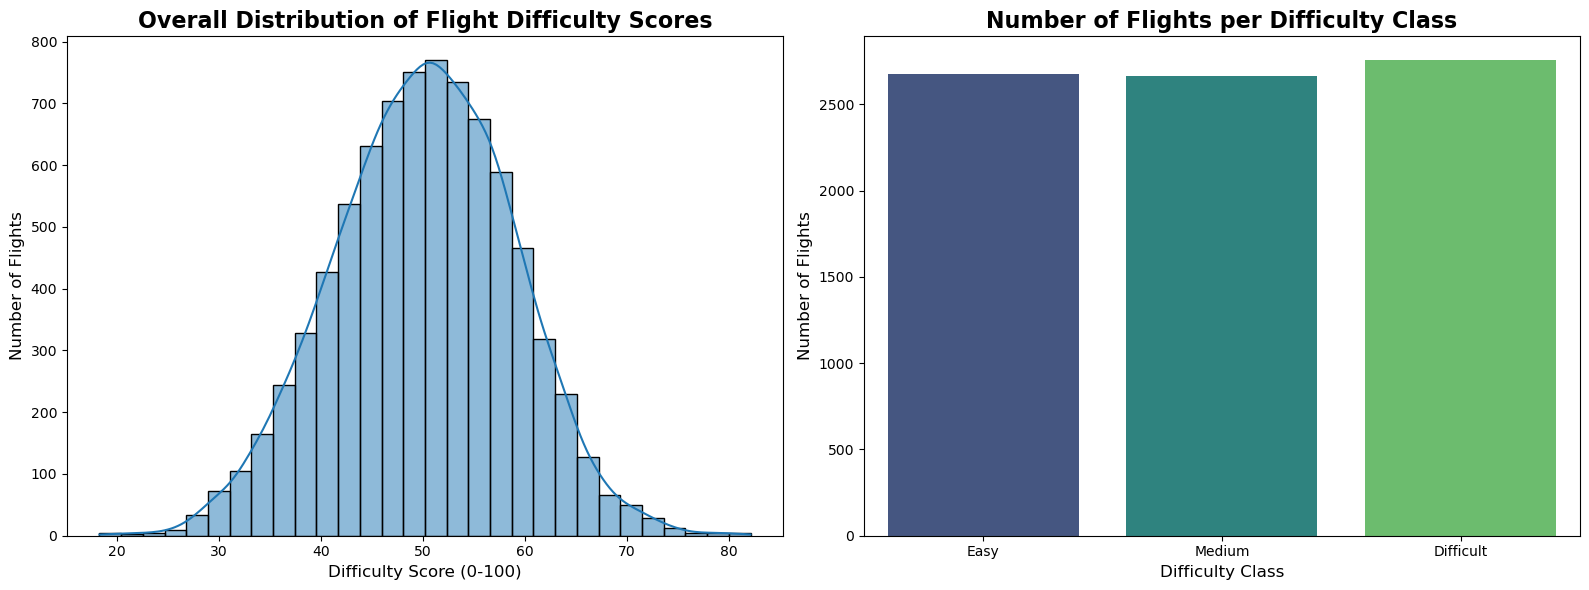

In [6]:
# Cell for Visualizing the Scoring Results

# --- First, we run the same scoring code to ensure the columns exist ---
difficulty_features = {
    'load_factor': True, 'ssr_per_pax': True, 'child_ratio': True, 'basic_economy_ratio': True,
    'bags_per_pax': True, 'is_international': True, 'ground_time_deficit': False,
    'fleet_complexity_score': True, 'time_pressure_score': True, 'is_high_risk_transfer': True
}
score_ranks = []
for feature, higher_is_worse in difficulty_features.items():
    rank_col = f'{feature}_rank'
    df[rank_col] = df.groupby('scheduled_departure_date_local')[feature].rank(pct=True)
    if not higher_is_worse: df[rank_col] = 1 - df[rank_col]
    score_ranks.append(rank_col)

df['difficulty_score'] = df[score_ranks].mean(axis=1) * 100
df['difficulty_rank_daily'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='dense', ascending=False)
df['difficulty_class'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].transform(
    lambda x: pd.qcut(x, q=[0, 0.33, 0.66, 1.0], labels=['Easy', 'Medium', 'Difficult'], duplicates='drop')
)

# --- NEW VISUALIZATION CODE ---

print("\n--- Visualizing the Scoring Results ---")

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Visualization 1: Distribution of the Difficulty Score ---
sns.histplot(df['difficulty_score'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Overall Distribution of Flight Difficulty Scores', fontsize=16, weight='bold')
axes[0].set_xlabel('Difficulty Score (0-100)', fontsize=12)
axes[0].set_ylabel('Number of Flights', fontsize=12)

# --- Visualization 2: Count of Flights in Each Difficulty Class ---
sns.countplot(x='difficulty_class', data=df, order=['Easy', 'Medium', 'Difficult'], palette='viridis', ax=axes[1])
axes[1].set_title('Number of Flights per Difficulty Class', fontsize=16, weight='bold')
axes[1].set_xlabel('Difficulty Class', fontsize=12)
axes[1].set_ylabel('Number of Flights', fontsize=12)

# --- Final Formatting ---
plt.tight_layout()
plt.show()

In [4]:
# Cell 7: Output and Verification
print("--- Top 15 Most Difficult Flights for a Sample Date (2025-08-10) ---")
sample_day_df = df[df['scheduled_departure_date_local'] == '2025-08-10']
display(sample_day_df[[
    'flight_number', 'scheduled_arrival_station_code', 'difficulty_score', 'difficulty_rank_daily', 'difficulty_class'
]].sort_values('difficulty_rank_daily').head(15))

--- Top 15 Most Difficult Flights for a Sample Date (2025-08-10) ---


,flight_number,scheduled_arrival_station_code,difficulty_score,difficulty_rank_daily,difficulty_class
1168,5557,OKC,73.411131,1.0,Difficult
7525,1198,CUN,71.391382,2.0,Difficult
3964,4809,ICT,70.215440,3.0,Difficult
5685,907,FRA,70.215440,3.0,Difficult
4524,4474,AVL,69.614004,4.0,Difficult
6569,1674,AUA,69.452424,5.0,Difficult
1527,1178,ORF,68.608618,6.0,Difficult
1429,359,MEX,68.473968,7.0,Difficult
7673,1270,PUJ,68.222621,8.0,Difficult
4273,1270,PUJ,68.222621,8.0,Difficult


In [5]:
# Save the final scored file for the other notebooks and the dashboard
df.to_csv('../output/test_TeamSamurai.csv', index=False)
print("\n✅ Final scored data saved to ../output/test_TeamSamurai.csv")


✅ Final scored data saved to ../output/test_TeamSamurai.csv
